# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [3]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

C:\Users\Mark\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


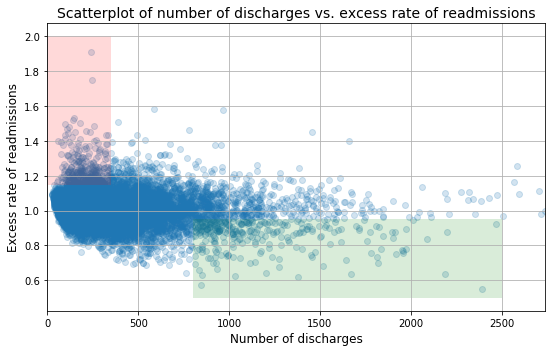

In [4]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

A. I do not agree with the recommendations given by the above analysis for a number of reasons:
* The comparison of the mean number of readmissions for small and large hospitals is performed without any statistical tests. The difference may not be statistically or practically significant; without performing significance testing, this can't be known.
* Smaller samples will always have greater variance than larger samples. It may be that no larger hospitals are observed with high readmission rates because of this effect.
* The "< 100" and "> 1,000" discharge thresholds for small and large hospitals, respectively, are not justified and may be arbitrary. A continuous analysis would likely be more appropriate.
* The policy recommendations do not necessarily follow from the analysis. Even if a genuine relationship exists between hospital size and readmission rates, there may be confounding factors unrelated to hospital quality that impact smaller hospitals negatively. For example, patients with more complex health needs might tend to live in rural areas, and rural areas might tend to have smaller hospitals. Any number of similar confounding factors might exist, so the conclusion that smaller hospitals deliver poor care or that hospital consolidation would be beneficial for readmission rates does not necessarily follow from the analysis performed.

# 1. Hypothesis Test
The null hypothesis is that the relationship between hospital size and readmission rates is zero.
The alternative hypothesis is that there is a non-zero relationship between hospital size and readmission rates.

This will be tested using bootstrap replicates. First, the function required for bootstrapping is declared.

In [63]:
def bootstrap_linreg(x, y, size=10000):
    """Takes in an array of x and an array of y, which are paired data, and a size as parameters. Performs linear regressions
    on the paried data and returns an array of slopes and an array of intercepts with length equal to the size parameter"""
    
    # Convert x and y to numpy arrays for use below
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Set up the index array, as well as an array for the slope and interept replicates
    ind = np.arange(len(x))
    slope_reps = np.empty(size)
    intercept_reps = np.empty(size)

    # Generate replicates by running a linear regression on each generated set of pairs.
    for i in range(size):
        test_ind = np.random.choice(ind, size=len(ind))
        test_x, test_y = x[test_ind], y[test_ind]
        slope_reps[i], intercept_reps[i] = np.polyfit(test_x, test_y, 1)

    return slope_reps, intercept_reps


Next, the bootstrap replicates are generated from the same data used in the analysis above.

In [64]:
# The same pairs of x-y values used in the analysis above are used.
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

# To generate a bootstrap sample for pairs of data, pass the x, y pairs to the bootstrap_linreg function
slopes, intercepts = bootstrap_linreg(x, y)

# 2. Significance Level

As shown below, none of the replicated slopes are greater than or equal to zero.

In [69]:
print('p = {}'.format(sum(slopes >= 0) / len(slopes)))

p = 0.0


# 3. Significance at 𝛼=.01

As demonstrated in the above, the p-value for the bootstrap replicates performed is 0.0 - out of 10,000 replications, not one achieved a non-negative association between hospital discharges (a proxy for hospital size) and readmission rates. This suggests that hospital size is negatively correlated with readmission rates, and is statistically significant at the 𝛼=.01 level.

# 4. Statistical vs. Practical Significance

As shown below, the median slope for the replicated linear regressions is -.0000286. This means that for every 1,000 additional hospital discharges, the likelihood of readmission decreases by about 2.86%, relative to expectation. 

Also shown below, the largest number of discharges at any hospital is 2,740, making the increase of 1,000 hospital discharges posited above an extreme scenario. This suggests small practical significance; making the smallest hospitals the size of the largest hospitals, which would likely be an impractical and very costly suggestion, would decrease readmission rates less than 10%, <i>ceteris paribus</i>. As discussed in the discussion in (A) above, there are reasons to believe that the <i>ceteris paribus</i> condition would not hold, making the results even less suggestive.

In [75]:
print('median slope: {}'.format(np.median(slopes)))
print('maximum discharges: {}'.format(np.max(x)))

median slope: -2.861283969615109e-05
maximum discharges: 2740


# 5. Scatterplots vs. Alternative Visualization

The scatterplot given above appears to show a more significant negative relationship between hospital size and hospital discharge rates than actually exists, making it misleading. 

The figure below may provide a less biased representation of the relationship. Overlaid on the scatter plot, it shows an arbitrary 100 bootstrap slope/intercept replicates. This makes it clear that, while a negative relationship almost certainly exists between the number of hospital discharges and the relative readmission rate, the relationship is not of large practical significance, even in each of 100 different replications.

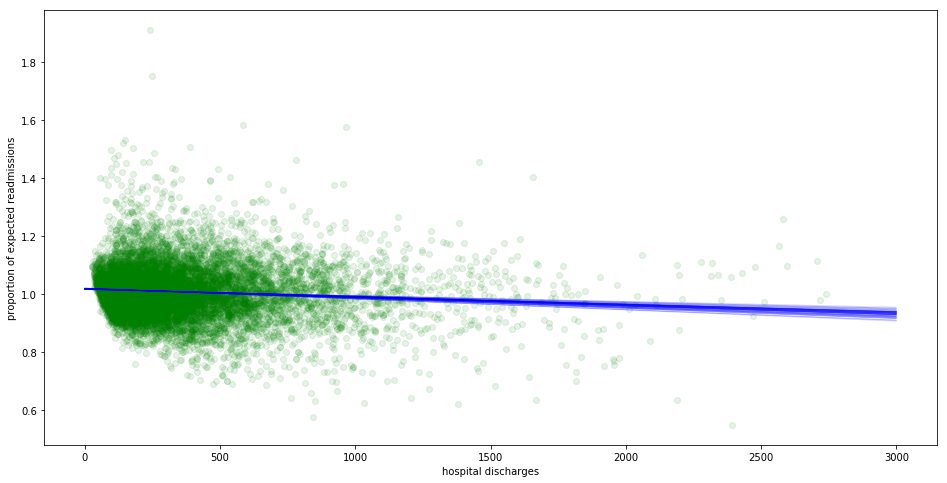

In [91]:
# Set the figure size to be large enough to evaluate
fig, ax = plt.subplots(figsize=(16, 8))

graph_x = np.array([0, 3000])
for i in range(100):
    _ = plt.plot(graph_x, slopes[i]*graph_x + intercepts[i], linewidth=0.5, alpha=0.2, color='blue')
    
_ = plt.scatter(x, y, alpha=.1, color='green')
_ = plt.xlabel('hospital discharges')
_ = plt.ylabel('proportion of expected readmissions')